Data: All GEO study descriptions, disease ground truth of a subset.  
Goal: explore how ground truth derives (->) best threshold and predicted annotations  

Ground truth: the true labels used to train txt2onto models.  
Best threshold: various cut off methods used on the predictions (probabilities) from txt2onto models.  
Predicted annotation: the classified binary annotation by applying the best threshold.  
1. ground truth (x) -> best threshold (y): explore how the best threshild is compared to the ground truth from which the best threshold is generated.  
2. best threshold (x) -> predicted annotation (y): explore how the predicted annotation is compared to the best threshild from which the predicted annotion is generated.  

Date: 2025-11-17  
Author: Junxia Lin  

In [9]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

In [10]:
# import the data
prior_df = pd.read_csv("../data/true_label__inst_type=sample__task=tissue.csv.gz", compression="gzip", sep=",")
ic_df = pd.read_csv("../data/UBERON_IC.csv", sep=",")
log2auprc_df = pd.read_csv("../data/tissue_model_stats.csv", sep=",")
id_map = pl.read_parquet("../data/UBERON_CL_id_map.parquet")
id_map = id_map.to_pandas()

folder_path = "../results/sampleLasso"
threshold_files = glob.glob(os.path.join(folder_path, "*_best_threshold.csv"))
threshold_dfs = [pd.read_csv(file, sep = "\t") for file in threshold_files]
annotation_analysis_files = glob.glob(os.path.join(folder_path, "threshold_annotation_analysis_*.csv"))
annotation_analysis_dfs = [pd.read_csv(file, sep=",") for file in annotation_analysis_files]

In [11]:
threshold_files, annotation_analysis_files

(['../results/sampleLasso/fbeta1.0_best_threshold.csv',
  '../results/sampleLasso/fbeta0.5_best_threshold.csv',
  '../results/sampleLasso/balanced_accuracy_best_threshold.csv',
  '../results/sampleLasso/mcc_best_threshold.csv'],
 ['../results/sampleLasso/threshold_annotation_analysis_mcc.csv',
  '../results/sampleLasso/threshold_annotation_analysis_balanced_accuracy.csv',
  '../results/sampleLasso/threshold_annotation_analysis_fbeta0.5.csv',
  '../results/sampleLasso/threshold_annotation_analysis_fbeta1.0.csv'])

In [12]:
threshold_dfs[0]["method"] = "balanced_accuracy"
threshold_dfs[1]["method"] = "mcc"
threshold_dfs[2]["method"] = "f1"
threshold_dfs[3]["method"] = "f05"
threshold_df = pd.concat(threshold_dfs, ignore_index=True)
threshold_df["log2(best_th/prior)"] = np.log2(threshold_df["best_threshold"]/threshold_df["prior"])
threshold_df = threshold_df.merge(id_map, left_on="task", right_on="id", how="left")
threshold_df = threshold_df.drop(columns=["id"])
threshold_df.head()

,task,best_threshold,prior,log2(auprc/prior),method,log2(best_th/prior),name
0,UBERON:0002435,0.002176,0.002660,7.855317,balanced_accuracy,-0.289453,striatum
1,UBERON:0000955,0.493446,0.020816,5.145668,balanced_accuracy,4.567101,brain
2,UBERON:0002020,0.838820,0.004789,7.466142,balanced_accuracy,7.452376,gray matter
3,UBERON:0000165,0.472976,0.001998,8.966938,balanced_accuracy,7.886777,mouth
4,CL:0000576,0.844903,0.004229,7.353881,balanced_accuracy,7.642215,monocyte


In [13]:
annotation_analysis_dfs[0]["method"] = "f05"
annotation_analysis_dfs[1]["method"] = "mcc"
annotation_analysis_dfs[2]["method"] = "balanced_accuracy"
annotation_analysis_dfs[3]["method"] = "f1"
annotation_analysis_df = pd.concat(annotation_analysis_dfs, ignore_index=True)
annotation_analysis_df = annotation_analysis_df.merge(id_map, left_on="task", right_on="id", how="left")
annotation_analysis_df = annotation_analysis_df.drop(columns=["id"])
annotation_analysis_df.head()

,task,best_threshold,prior,num_of_pos,num_of_pred_pos,method,name
0,UBERON:0002435,0.002176,0.000579,18,33,f05,striatum
1,UBERON:0000955,0.493446,0.036780,1204,3082,f05,brain
2,UBERON:0002020,0.838820,0.013444,427,104,f05,gray matter
3,UBERON:0000165,0.472976,0.030978,951,260,f05,mouth
4,CL:0000576,0.844903,0.006238,166,166,f05,monocyte


In [14]:
threshold_df["method"].value_counts(), annotation_analysis_df["method"].value_counts()

(method
 balanced_accuracy    222
 mcc                  222
 f1                   222
 f05                  222
 Name: count, dtype: int64,
 method
 f05                  222
 mcc                  222
 balanced_accuracy    222
 f1                   222
 Name: count, dtype: int64)

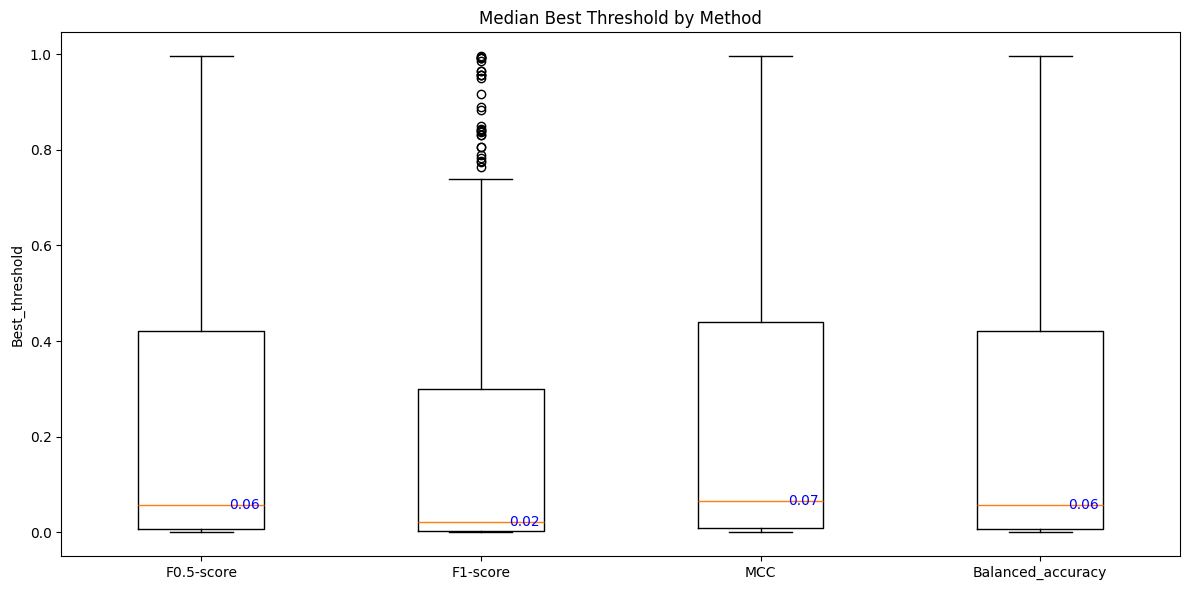

In [15]:
# boxplot for the best threshold
y_axis = "best_threshold"
plt.figure(figsize=(12, 6))
plt.boxplot([threshold_df[threshold_df["method"] == "f05"][y_axis], threshold_df[threshold_df["method"] == "f1"][y_axis], threshold_df[threshold_df["method"] == "mcc"][y_axis], threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis]])
median_value_f05 = threshold_df[threshold_df["method"] == "f05"][y_axis].median()
median_value_f1 = threshold_df[threshold_df["method"] == "f1"][y_axis].median()
median_value_mcc = threshold_df[threshold_df["method"] == "mcc"][y_axis].median()
median_value_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis].median()
plt.text(1.1, median_value_f05, f"{median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(2.1, median_value_f1, f"{median_value_f1:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(3.1, median_value_mcc, f"{median_value_mcc:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(4.1, median_value_ba, f"{median_value_ba:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.xticks([1, 2, 3, 4], ['F0.5-score', 'F1-score', 'MCC', 'Balanced_accuracy'])
plt.ylabel(y_axis.capitalize())
plt.title("Median Best Threshold by Method")
plt.tight_layout()
# Show the plot
plt.show()

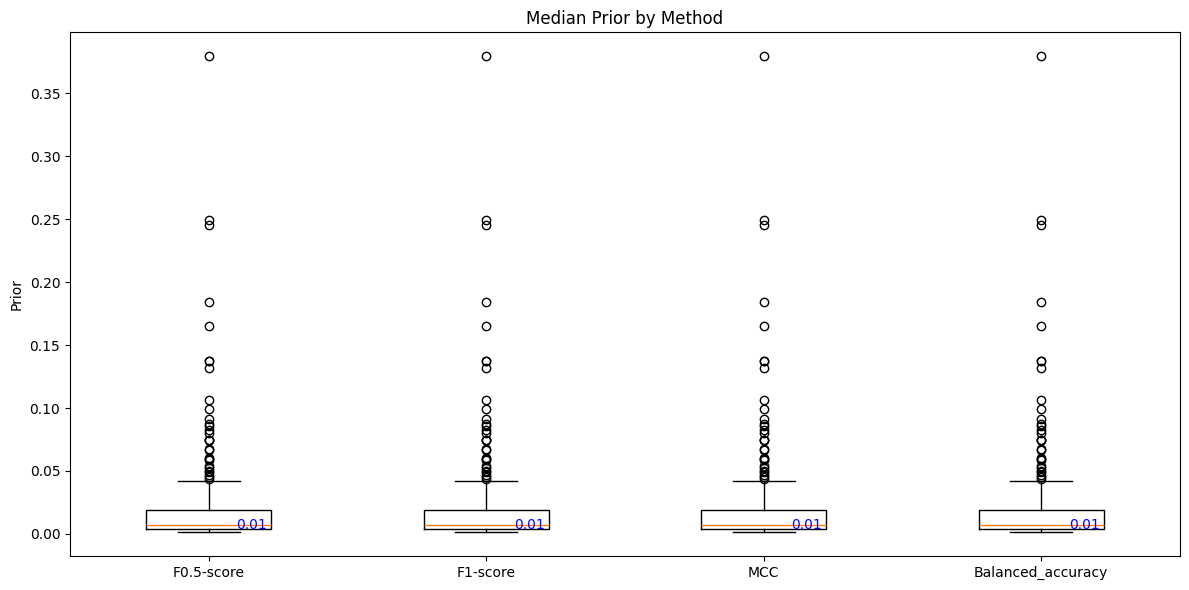

In [16]:
# boxplot for prior
y_axis = "prior"
plt.figure(figsize=(12, 6))
plt.boxplot([threshold_df[threshold_df["method"] == "f05"][y_axis], threshold_df[threshold_df["method"] == "f1"][y_axis], threshold_df[threshold_df["method"] == "mcc"][y_axis], threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis]])
median_value_f05 = threshold_df[threshold_df["method"] == "f05"][y_axis].median()
median_value_f1 = threshold_df[threshold_df["method"] == "f1"][y_axis].median()
median_value_mcc = threshold_df[threshold_df["method"] == "mcc"][y_axis].median()
median_value_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis].median()
plt.text(1.1, median_value_f05, f"{median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(2.1, median_value_f1, f"{median_value_f1:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(3.1, median_value_mcc, f"{median_value_mcc:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(4.1, median_value_ba, f"{median_value_ba:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.xticks([1, 2, 3, 4], ['F0.5-score', 'F1-score', 'MCC', 'Balanced_accuracy'])
plt.ylabel(y_axis.capitalize())
plt.title("Median Prior by Method")
plt.tight_layout()
# Show the plot
plt.show()

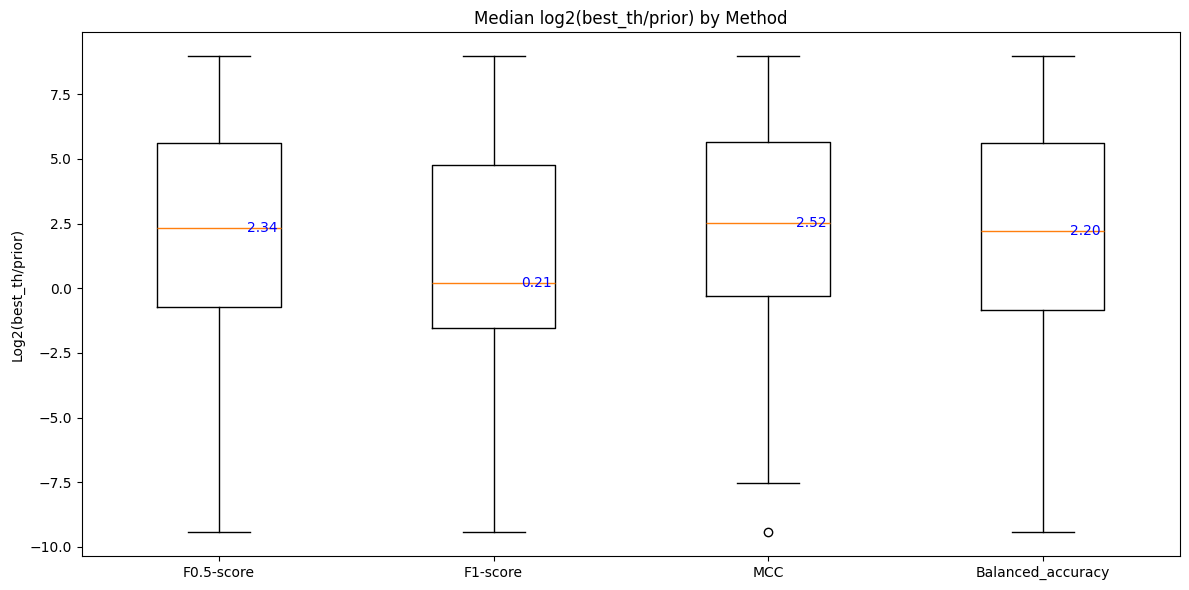

In [17]:
# boxplot for the best threshold/prior log2 ratio
y_axis = "log2(best_th/prior)"
plt.figure(figsize=(12, 6))
plt.boxplot([threshold_df[threshold_df["method"] == "f05"][y_axis], threshold_df[threshold_df["method"] == "f1"][y_axis], threshold_df[threshold_df["method"] == "mcc"][y_axis], threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis]])
median_value_f05 = threshold_df[threshold_df["method"] == "f05"][y_axis].median()
median_value_f1 = threshold_df[threshold_df["method"] == "f1"][y_axis].median()
median_value_mcc = threshold_df[threshold_df["method"] == "mcc"][y_axis].median()
median_value_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis].median()
plt.text(1.1, median_value_f05, f"{median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(2.1, median_value_f1, f"{median_value_f1:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(3.1, median_value_mcc, f"{median_value_mcc:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(4.1, median_value_ba, f"{median_value_ba:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.xticks([1, 2, 3, 4], ['F0.5-score', 'F1-score', 'MCC', 'Balanced_accuracy'])
plt.ylabel(y_axis.capitalize())
plt.title("Median log2(best_th/prior) by Method")
plt.tight_layout()
# Show the plot
plt.show()

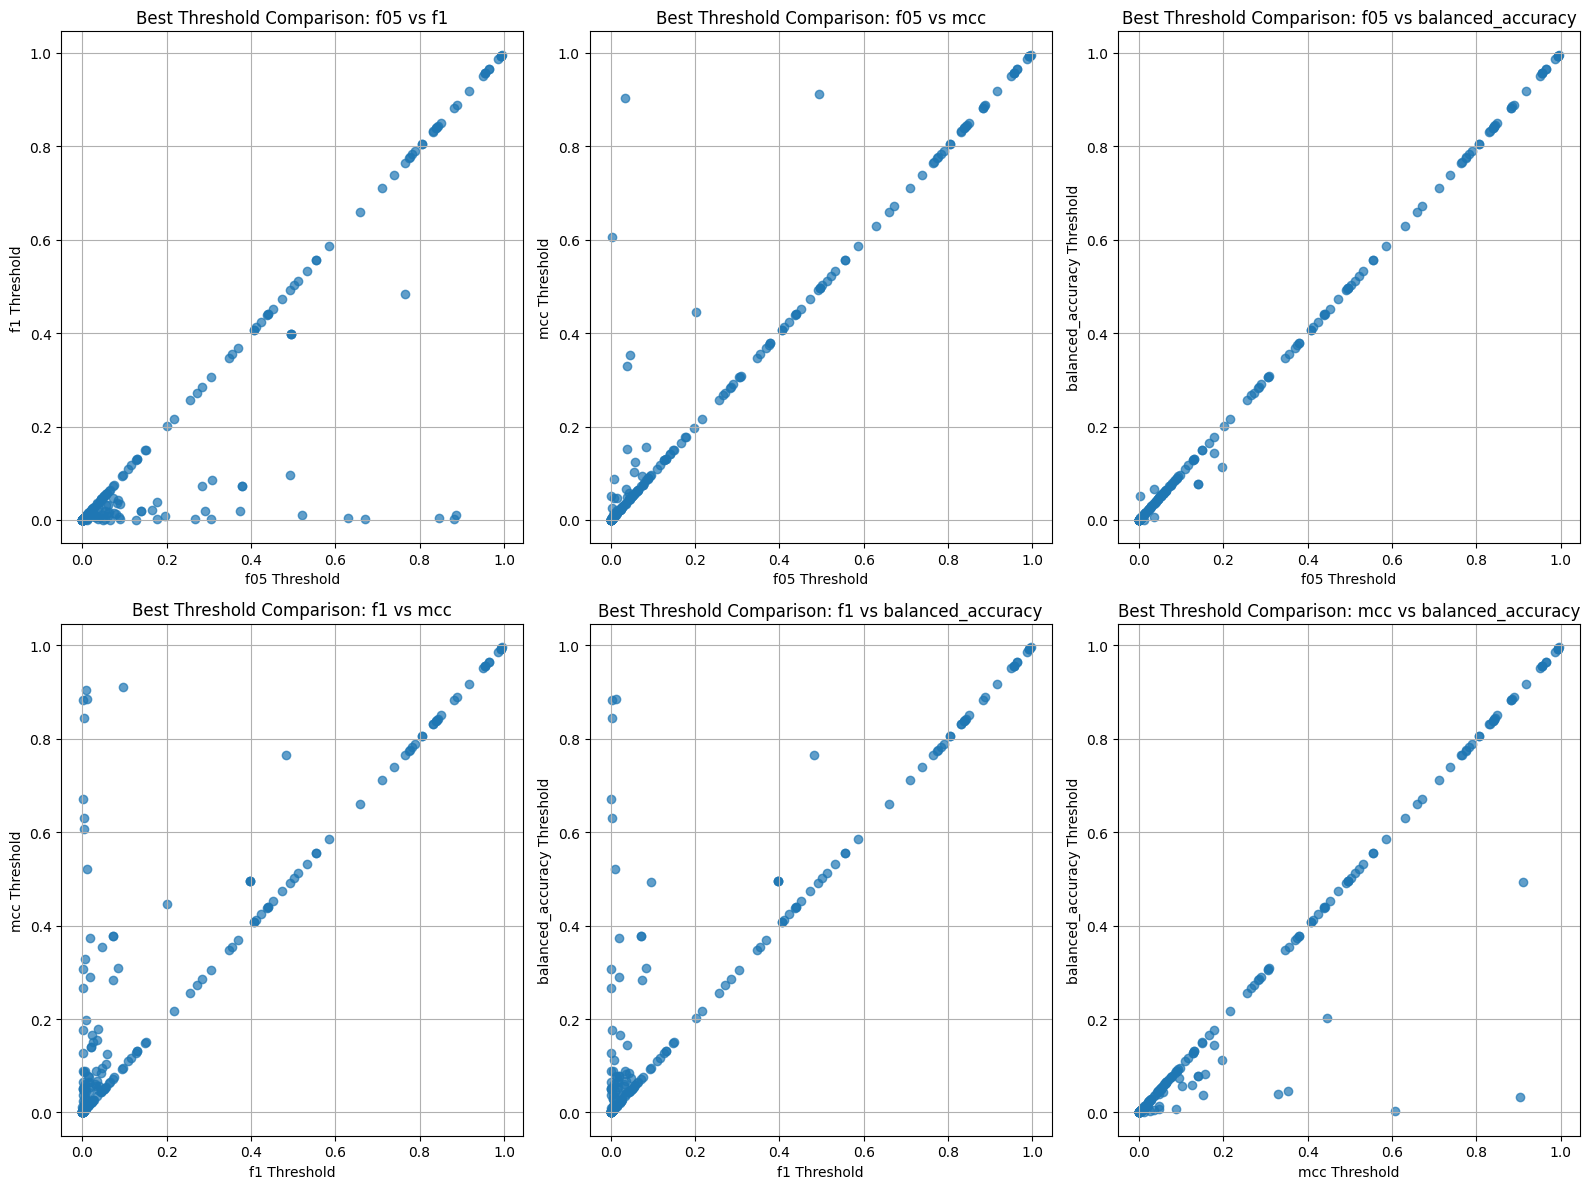

In [18]:
import itertools
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
threshold_pivot_df = threshold_df.pivot(index="task", columns="method", values="best_threshold")

method_pairs = list(itertools.combinations(methods, 2))

plt.figure(figsize=(16, 12))

for i, (m1, m2) in enumerate(method_pairs, 1):
    plt.subplot(2, 3, i)
    plt.scatter(threshold_pivot_df[m1], threshold_pivot_df[m2], alpha=0.7)
    
    # Add diagonal line
    # min_val = min(threshold_pivot_df[m1].min(), threshold_pivot_df[m2].min())
    # max_val = max(threshold_pivot_df[m1].max(), threshold_pivot_df[m2].max())
    # plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1)
    
    plt.xlabel(f"{m1} Threshold")
    plt.ylabel(f"{m2} Threshold")
    plt.title(f"Best Threshold Comparison: {m1} vs {m2}")
    plt.grid(True)

plt.tight_layout()
plt.show()



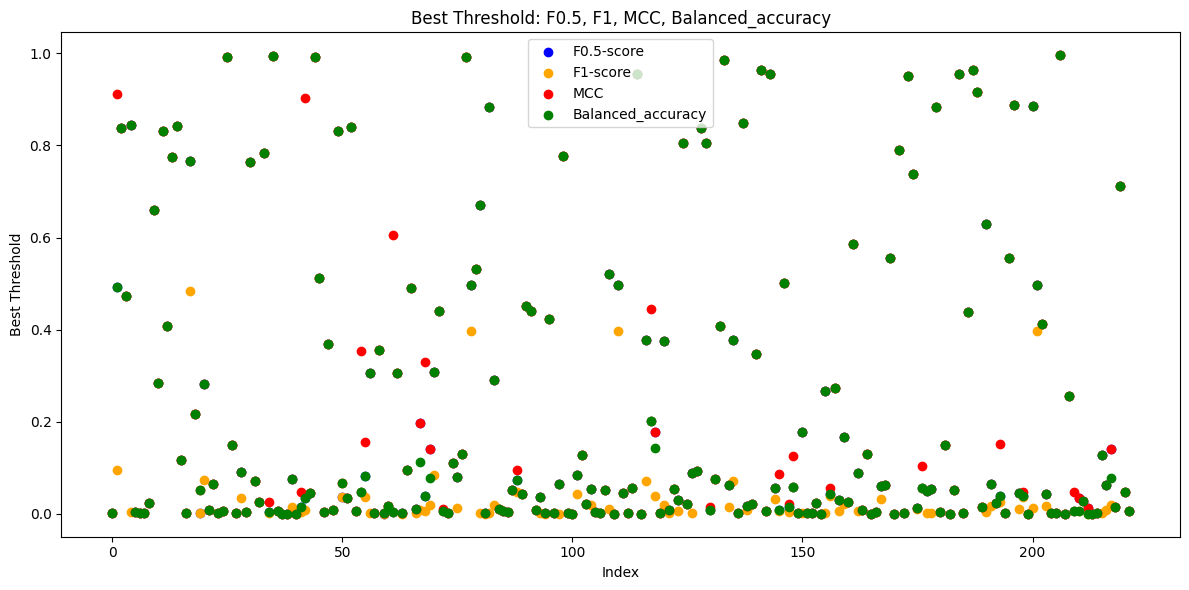

In [19]:
# scatter plot: best_threshold
plt.figure(figsize=(12,6))
plt.scatter(threshold_df[threshold_df["method"] == "f05"].reset_index().index, threshold_df[threshold_df["method"] == "f05"]["best_threshold"], label='F0.5-score', c="blue")
plt.scatter(threshold_df[threshold_df["method"] == "f1"].reset_index().index, threshold_df[threshold_df["method"] == "f1"]["best_threshold"], label='F1-score', c="orange")
plt.scatter(threshold_df[threshold_df["method"] == "mcc"].reset_index().index, threshold_df[threshold_df["method"] == "mcc"]["best_threshold"], label='MCC', c="red")
plt.scatter(threshold_df[threshold_df["method"] == "balanced_accuracy"].reset_index().index, threshold_df[threshold_df["method"] == "balanced_accuracy"]["best_threshold"], label='Balanced_accuracy', c="green")
plt.xlabel("Index")
plt.ylabel("Best Threshold")
plt.title("Best Threshold: F0.5, F1, MCC, Balanced_accuracy")
plt.legend()
plt.tight_layout()
# Show the plot
plt.show()

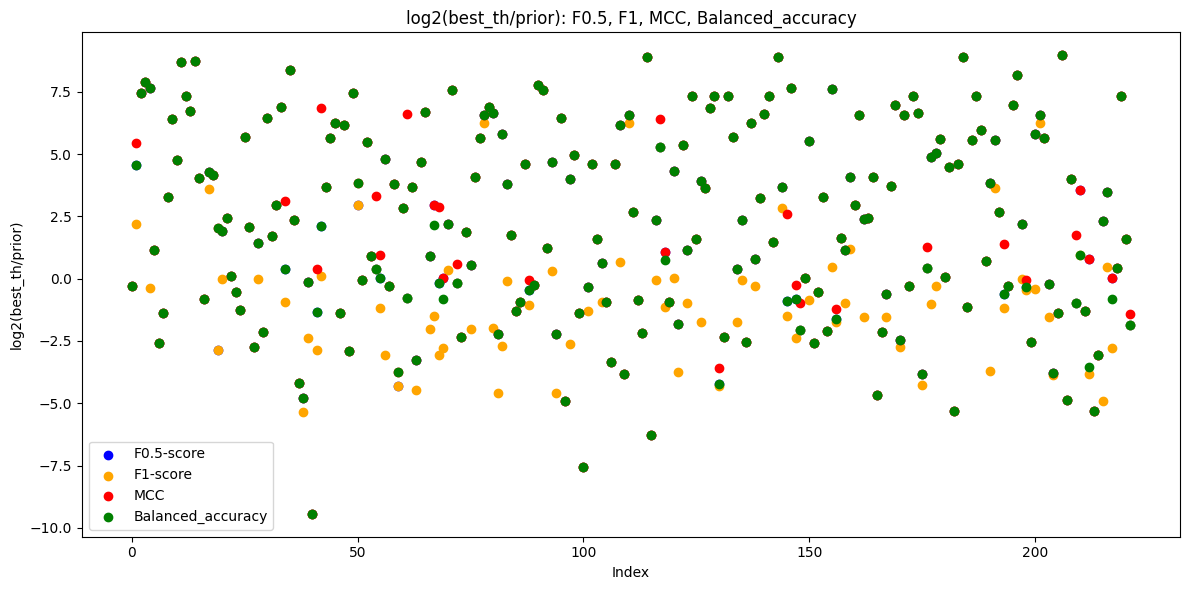

In [20]:
# scatter plot: log2(best_th/prior)
plt.figure(figsize=(12,6))
plt.scatter(threshold_df[threshold_df["method"] == "f05"].reset_index().index, threshold_df[threshold_df["method"] == "f05"]["log2(best_th/prior)"], label='F0.5-score', c="blue")
plt.scatter(threshold_df[threshold_df["method"] == "f1"].reset_index().index, threshold_df[threshold_df["method"] == "f1"]["log2(best_th/prior)"], label='F1-score', c="orange")
plt.scatter(threshold_df[threshold_df["method"] == "mcc"].reset_index().index, threshold_df[threshold_df["method"] == "mcc"]["log2(best_th/prior)"], label='MCC', c="red")
plt.scatter(threshold_df[threshold_df["method"] == "balanced_accuracy"].reset_index().index, threshold_df[threshold_df["method"] == "balanced_accuracy"]["log2(best_th/prior)"], label='Balanced_accuracy', c="green")
plt.xlabel("Index")
plt.ylabel("log2(best_th/prior)")
plt.title("log2(best_th/prior): F0.5, F1, MCC, Balanced_accuracy")
plt.legend()
plt.tight_layout()
# Show the plot
plt.show()

In [21]:
# the top terms with the highest threshold
threshold_df_top10_f05 = threshold_df[threshold_df["method"] == "f05"].sort_values(by="best_threshold", ascending = False)["name"].head(10)
threshold_df_top10_f1 = threshold_df[threshold_df["method"] == "f1"].sort_values(by="best_threshold", ascending = False)["name"].head(10)
threshold_df_top10_mcc = threshold_df[threshold_df["method"] == "mcc"].sort_values(by="best_threshold", ascending = False)["name"].head(10)
threshold_df_top10_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"].sort_values(by="best_threshold", ascending = False)["name"].head(10)

In [22]:
threshold_df_top10_f05, threshold_df_top10_f1

(872                         cerebral hemisphere
 701                           brain gray matter
 691                    male accessory sex gland
 743                          reproductive gland
 710                     male reproductive gland
 799                              prostate gland
 807    central nervous system gray matter layer
 853              nervous system cell part layer
 850                            olfactory cortex
 809                             piriform cortex
 Name: name, dtype: object,
 650                         cerebral hemisphere
 479                           brain gray matter
 469                    male accessory sex gland
 521                          reproductive gland
 488                     male reproductive gland
 577                              prostate gland
 585    central nervous system gray matter layer
 631              nervous system cell part layer
 628                            olfactory cortex
 587                             piriform

In [23]:
threshold_df_top10_mcc, threshold_df_top10_ba

(428                         cerebral hemisphere
 257                           brain gray matter
 247                    male accessory sex gland
 299                          reproductive gland
 266                     male reproductive gland
 355                              prostate gland
 363    central nervous system gray matter layer
 409              nervous system cell part layer
 406                            olfactory cortex
 365                             piriform cortex
 Name: name, dtype: object,
 206                         cerebral hemisphere
 35                            brain gray matter
 25                     male accessory sex gland
 77                           reproductive gland
 44                      male reproductive gland
 133                              prostate gland
 141    central nervous system gray matter layer
 187              nervous system cell part layer
 184                            olfactory cortex
 143                             piriform

In [24]:
# the top terms with the highest prior
annotation_analysis_df_top10_f05 = annotation_analysis_df[annotation_analysis_df["method"] == "f05"].sort_values(by="prior", ascending = False)["name"].head(10)
annotation_analysis_df_top10_f1 = annotation_analysis_df[annotation_analysis_df["method"] == "f1"].sort_values(by="prior", ascending = False)["name"].head(10)
annotation_analysis_df_top10_mcc = annotation_analysis_df[annotation_analysis_df["method"] == "mcc"].sort_values(by="prior", ascending = False)["name"].head(10)
annotation_analysis_df_top10_ba = annotation_analysis_df[annotation_analysis_df["method"] == "balanced_accuracy"].sort_values(by="prior", ascending = False)["name"].head(10)

In [25]:
annotation_analysis_df_top10_f05, annotation_analysis_df_top10_f1

(131                                         blood
 148                                     leukocyte
 88                               mononuclear cell
 156                               digestive tract
 113                      digestive system element
 101                subdivision of digestive tract
 130                               skeletal system
 68                                    bone marrow
 51     alimentary part of gastrointestinal system
 157                                     intestine
 Name: name, dtype: object,
 797                                         blood
 814                                     leukocyte
 754                              mononuclear cell
 822                               digestive tract
 779                      digestive system element
 767                subdivision of digestive tract
 796                               skeletal system
 734                                   bone marrow
 717    alimentary part of gastrointestinal system
 82

In [26]:
annotation_analysis_df_top10_mcc, annotation_analysis_df_top10_ba

(353                                         blood
 370                                     leukocyte
 310                              mononuclear cell
 378                               digestive tract
 335                      digestive system element
 323                subdivision of digestive tract
 352                               skeletal system
 290                                   bone marrow
 273    alimentary part of gastrointestinal system
 379                                     intestine
 Name: name, dtype: object,
 575                                         blood
 592                                     leukocyte
 532                              mononuclear cell
 600                               digestive tract
 557                      digestive system element
 545                subdivision of digestive tract
 574                               skeletal system
 512                                   bone marrow
 495    alimentary part of gastrointestinal system
 60

Analysis:

1. In general, the best threshold across the methods are very similar with F1's being the lowest.  
2. From the best threshold comparisons, the best threshold is generally higher in F0.5 compared to F1, which is what we expected. 

### txt2onto models GT label & performance

In [27]:
# combine the best threshold, prior, ic, pos, logarprc
txt2onto_label_dfs = []
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
for m in methods:
    df = threshold_df[threshold_df["method"] == m]
    prior = []
    ic = []
    pos = []
    auprcprior = []
    for i in df["task"]:
        prior_df_sub = prior_df[["Unnamed: 0", i]]
        prior_df_sub = prior_df_sub[(prior_df_sub != 0).all(axis=1)]
        prior_df_sub[i] = prior_df_sub[i].replace(-1, 0)
        prior.append(prior_df_sub[i].mean())
        ic_value = ic_df.loc[ic_df['node'] == i, 'IC'].values[0]
        ic.append(ic_value)
        pos_value = log2auprc_df.loc[log2auprc_df['ID'] == i, 'num_of_pos'].values[0]
        pos.append(pos_value)
        auprc_value = log2auprc_df.loc[log2auprc_df['ID'] == i, 'log2(auprc/prior)'].values[0]
        auprcprior.append(auprc_value)

    # data used to train txt2onto
    txt2onto_label = pd.DataFrame({"task": df["task"], "best_threshold": df["best_threshold"], "prior": prior, "ic": ic, "num_of_pos": pos, "log2(auprc/prior)": auprcprior})
    txt2onto_label = txt2onto_label.merge(id_map, left_on="task", right_on="id", how="left")
    txt2onto_label = txt2onto_label.drop(columns=["id"])
    txt2onto_label["method"] = m
    txt2onto_label_dfs.append(txt2onto_label)
txt2onto_label_df = pd.concat(txt2onto_label_dfs, ignore_index=True)
txt2onto_label_df.head()
    

,task,best_threshold,prior,ic,num_of_pos,log2(auprc/prior),name,method
0,UBERON:0002435,0.002176,0.000475,6.200953,10,9.390408,striatum,f05
1,UBERON:0000955,0.493446,0.085881,2.067788,2394,3.632799,brain,f05
2,UBERON:0002020,0.838820,0.016515,2.488143,387,3.393686,gray matter,f05
3,UBERON:0000165,0.472976,0.008627,2.936865,286,3.000259,mouth,f05
4,CL:0000576,0.844903,0.011456,7.268793,304,5.531797,monocyte,f05


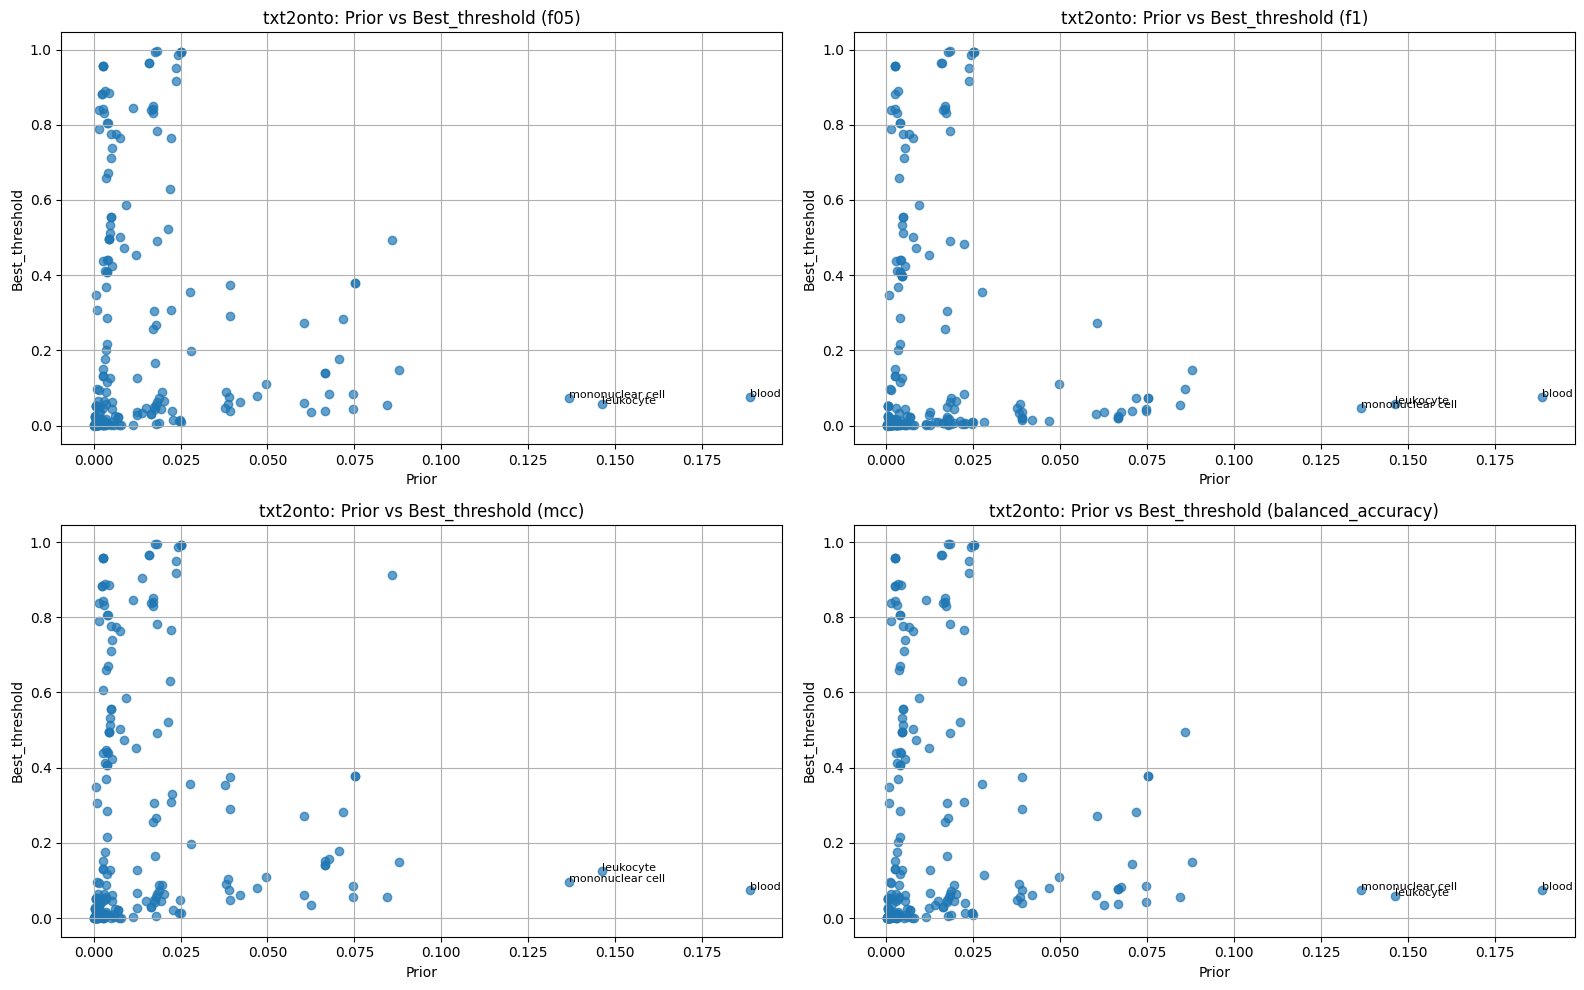

In [33]:
# Prior vs Best Threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "prior"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[x_axis] > 0.125:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'txt2onto: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

Analysis:

1. No obvious correlation between prior and best threshold across the methods. 

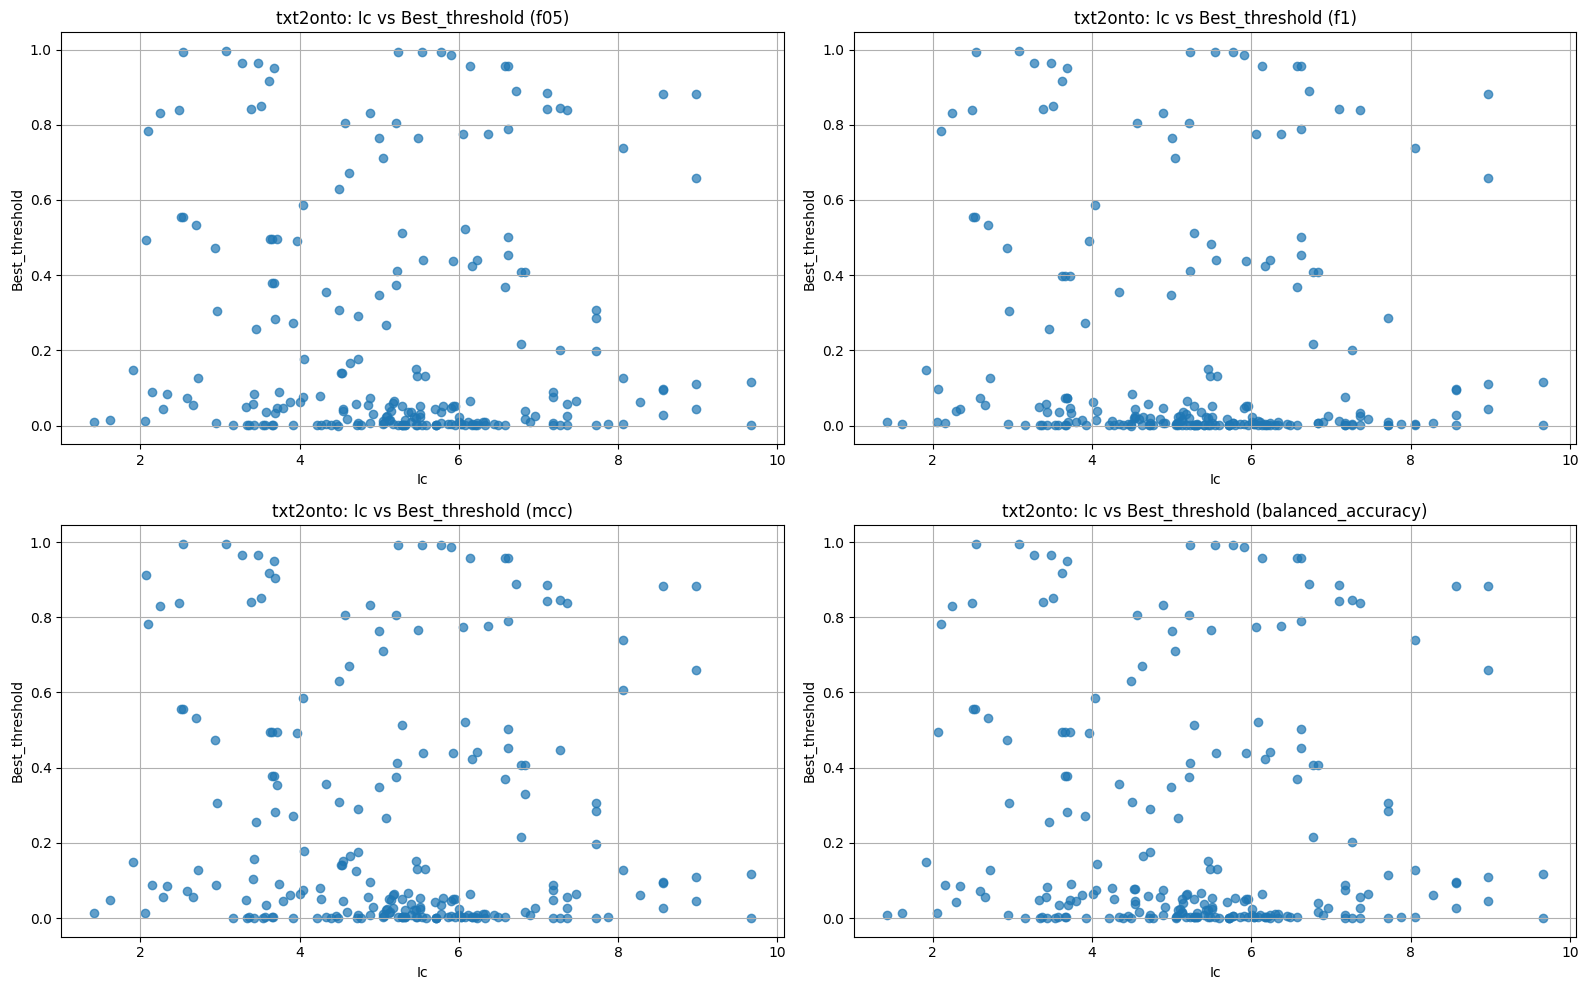

In [34]:
# Information Content vs Best Threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "ic"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    # for i, row in subset.iterrows():
    #     if row[x_axis] > 0.1:
    #         plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    # if method in ["balanced_accuracy", "mcc"]:
    #     for i, row in subset.iterrows():
    #         if row[y_axis] > 0.6:
    #             plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'txt2onto: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

Analysis:

1. No obvious relationship between information content and best threshold. 

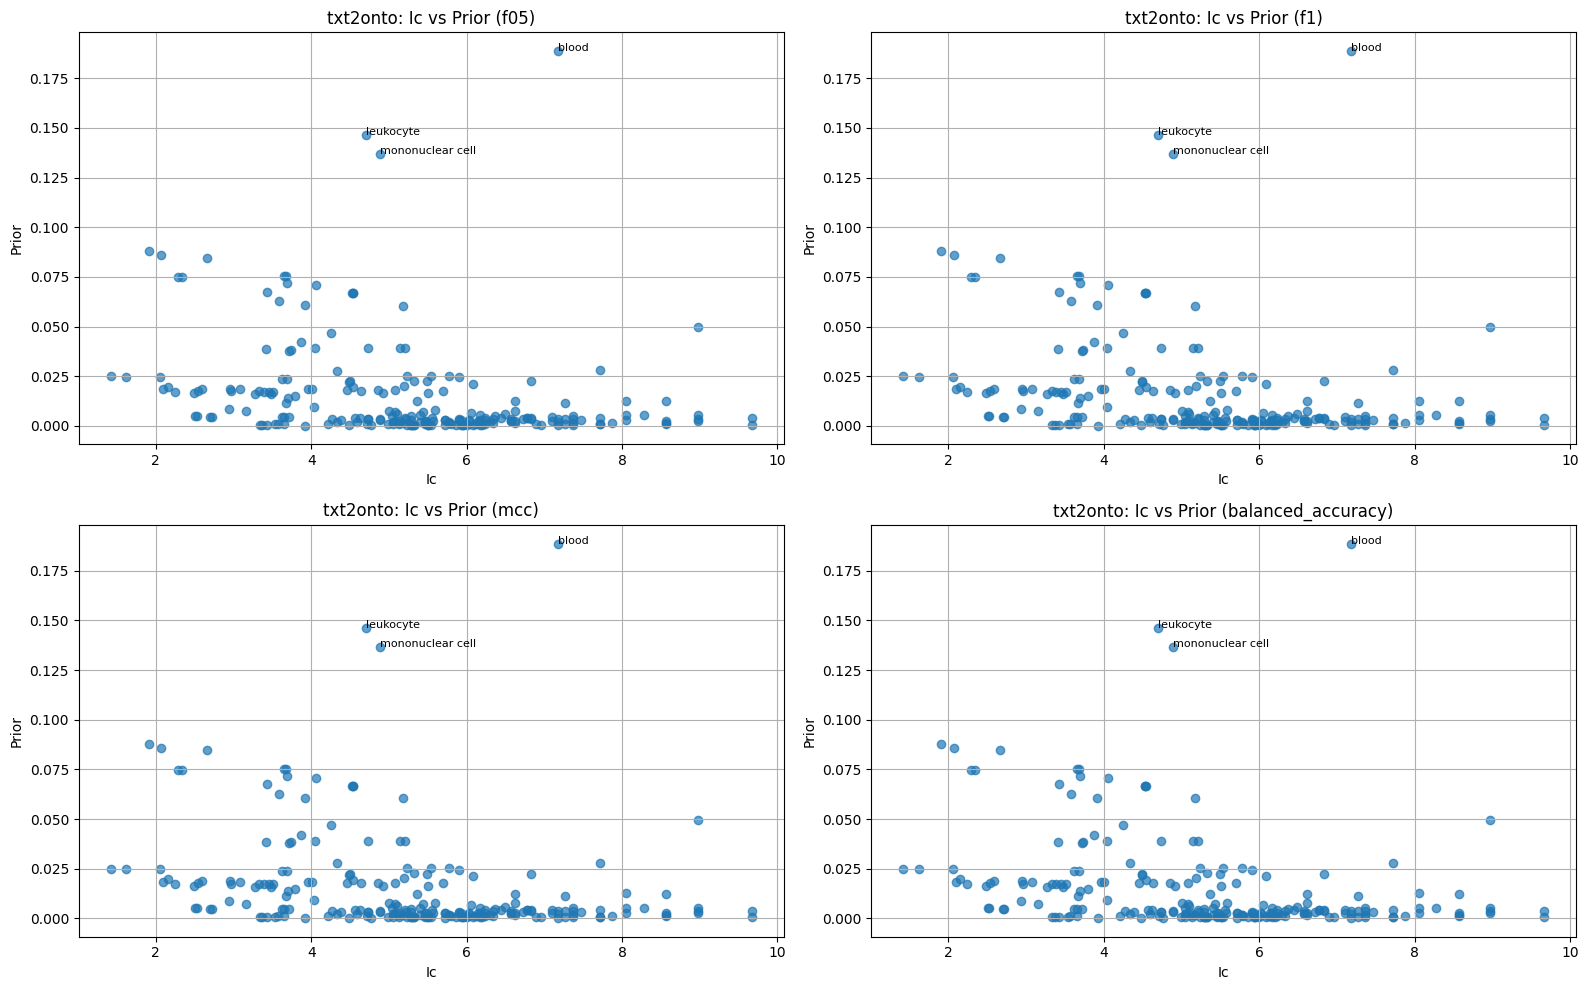

In [38]:
# IC vs Prior
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "ic"
y_axis = "prior"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 0.125:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'txt2onto: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

Analysis:

1. negative relationship between information content and prior.  
2. the specific terms have lower prior.  

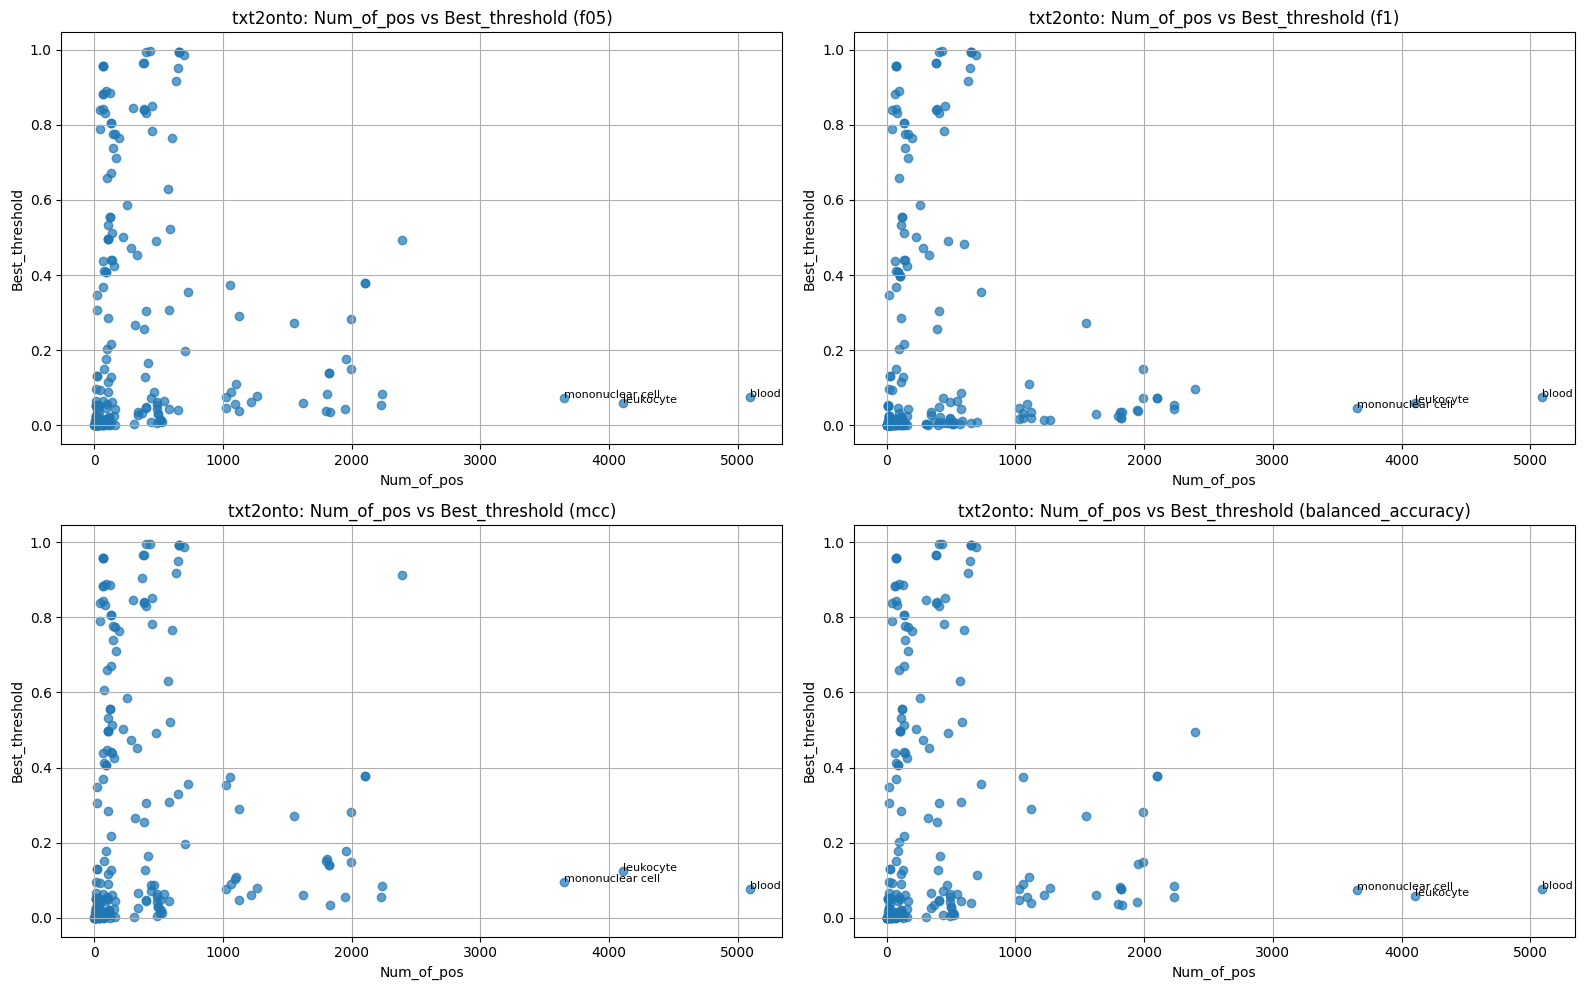

In [40]:
# Number of Positives vs best_threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "num_of_pos"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[x_axis] > 3000:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'txt2onto: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

Analysis:

1. No obvious relationship between number of positives and best threshold.  

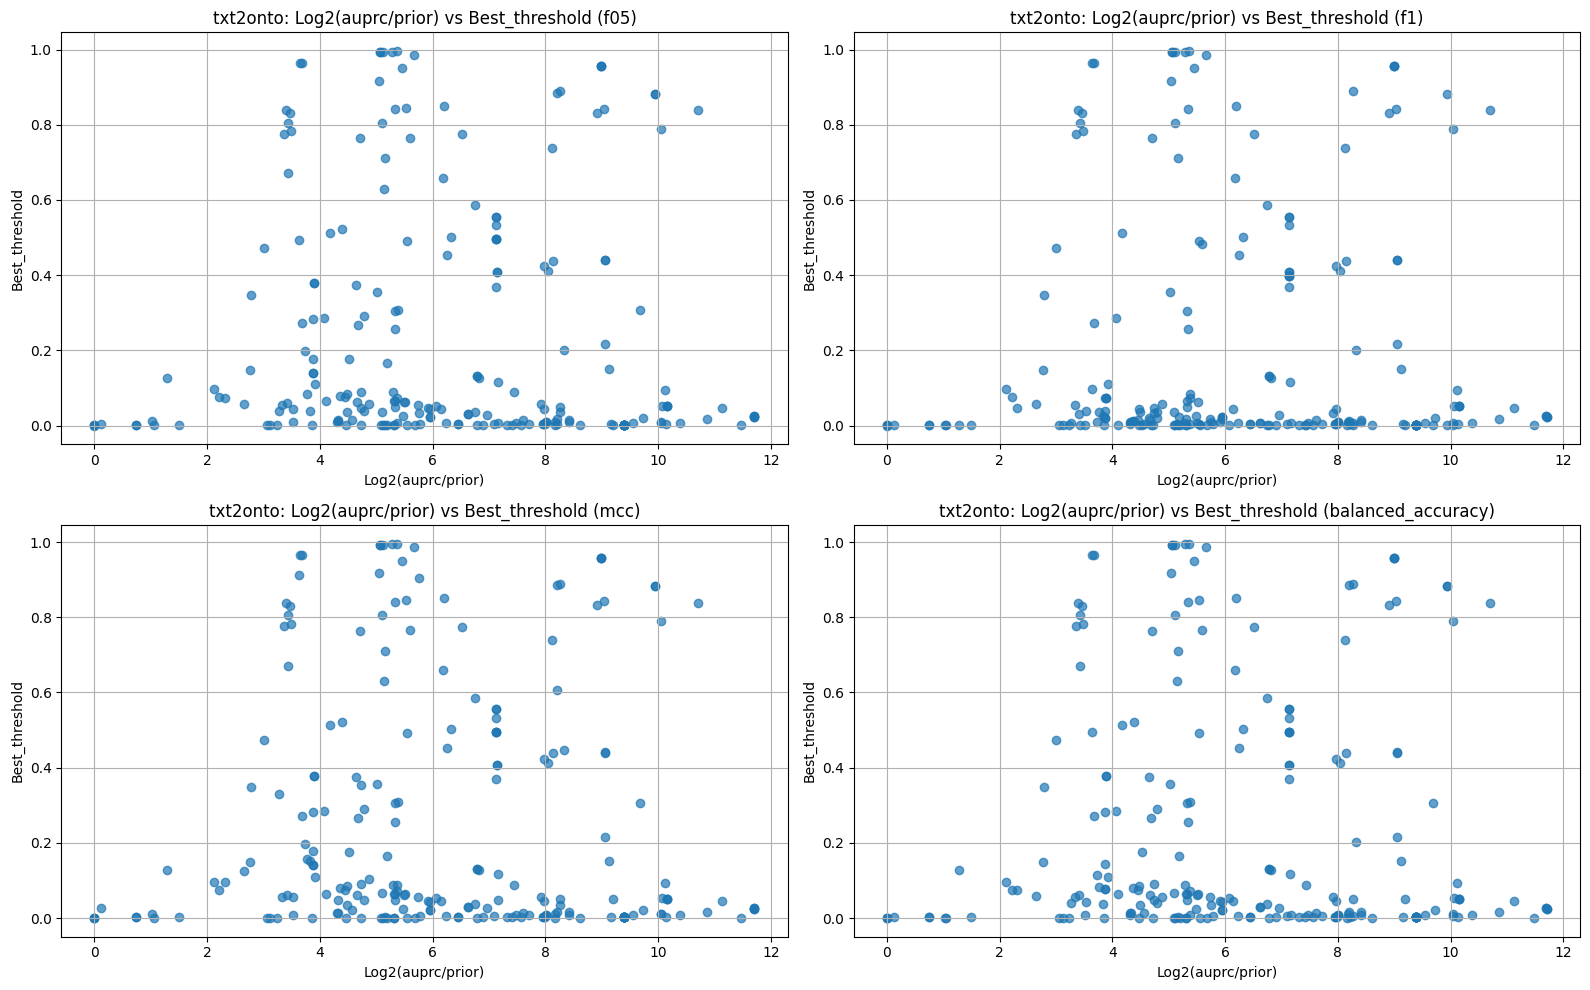

In [42]:
# log2(auprc/prior) vs best_threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "log2(auprc/prior)"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    # for i, row in subset.iterrows():
    #     if row[y_axis] > 0.3:
    #         plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'txt2onto: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

Analysis:

1. No obvious correlation between log2(auprc/prior) and best threshold.  It means the model performance has no relationship with the best threshold. 

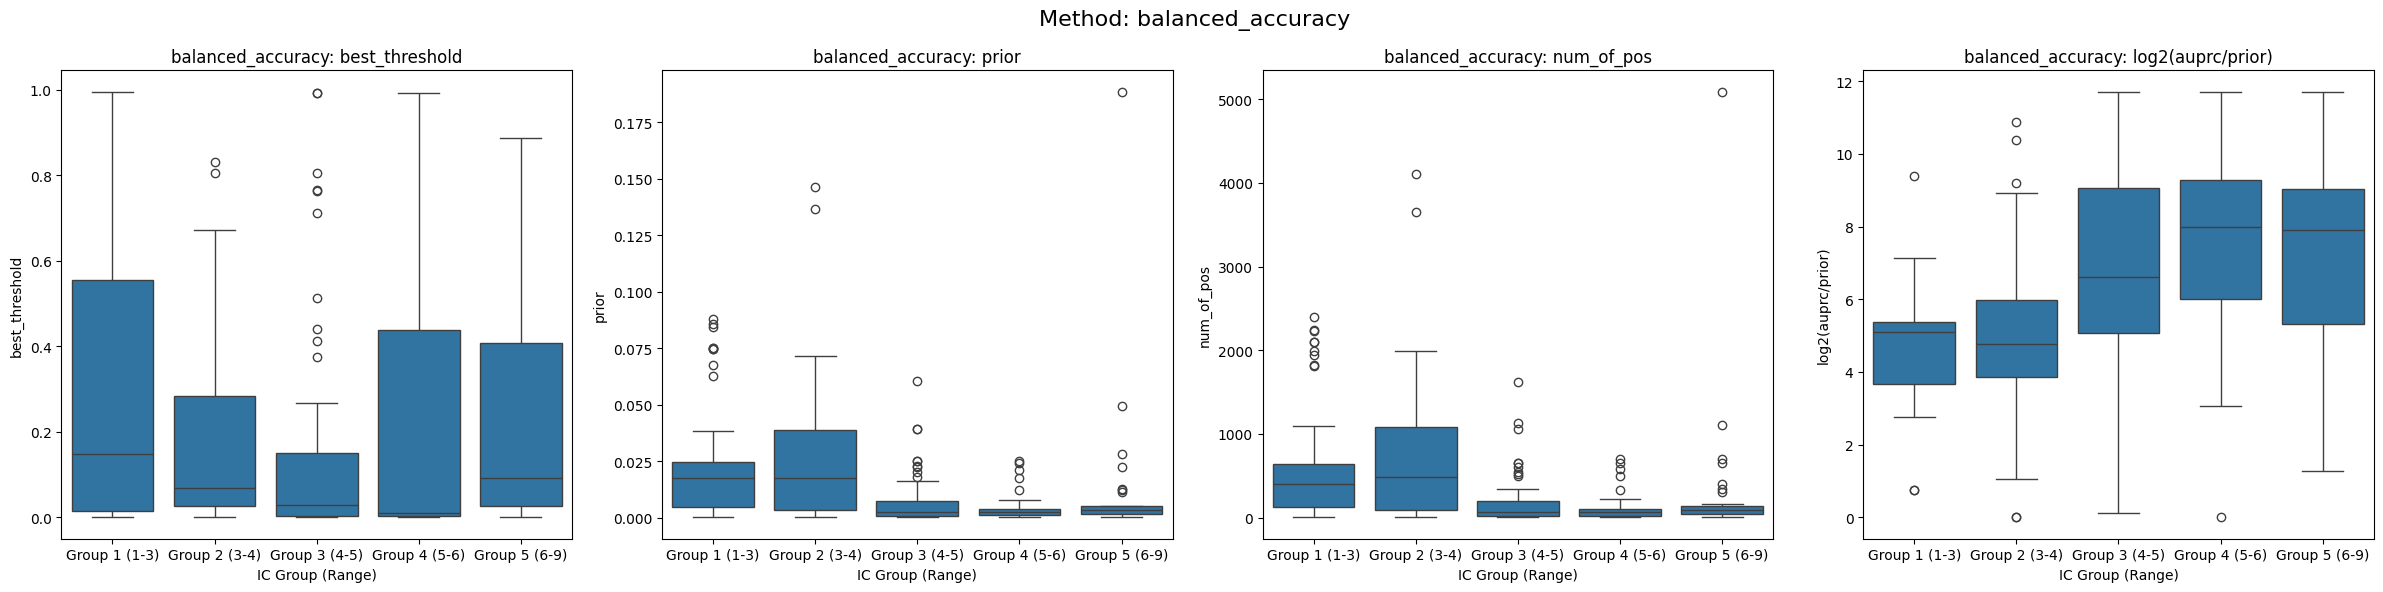

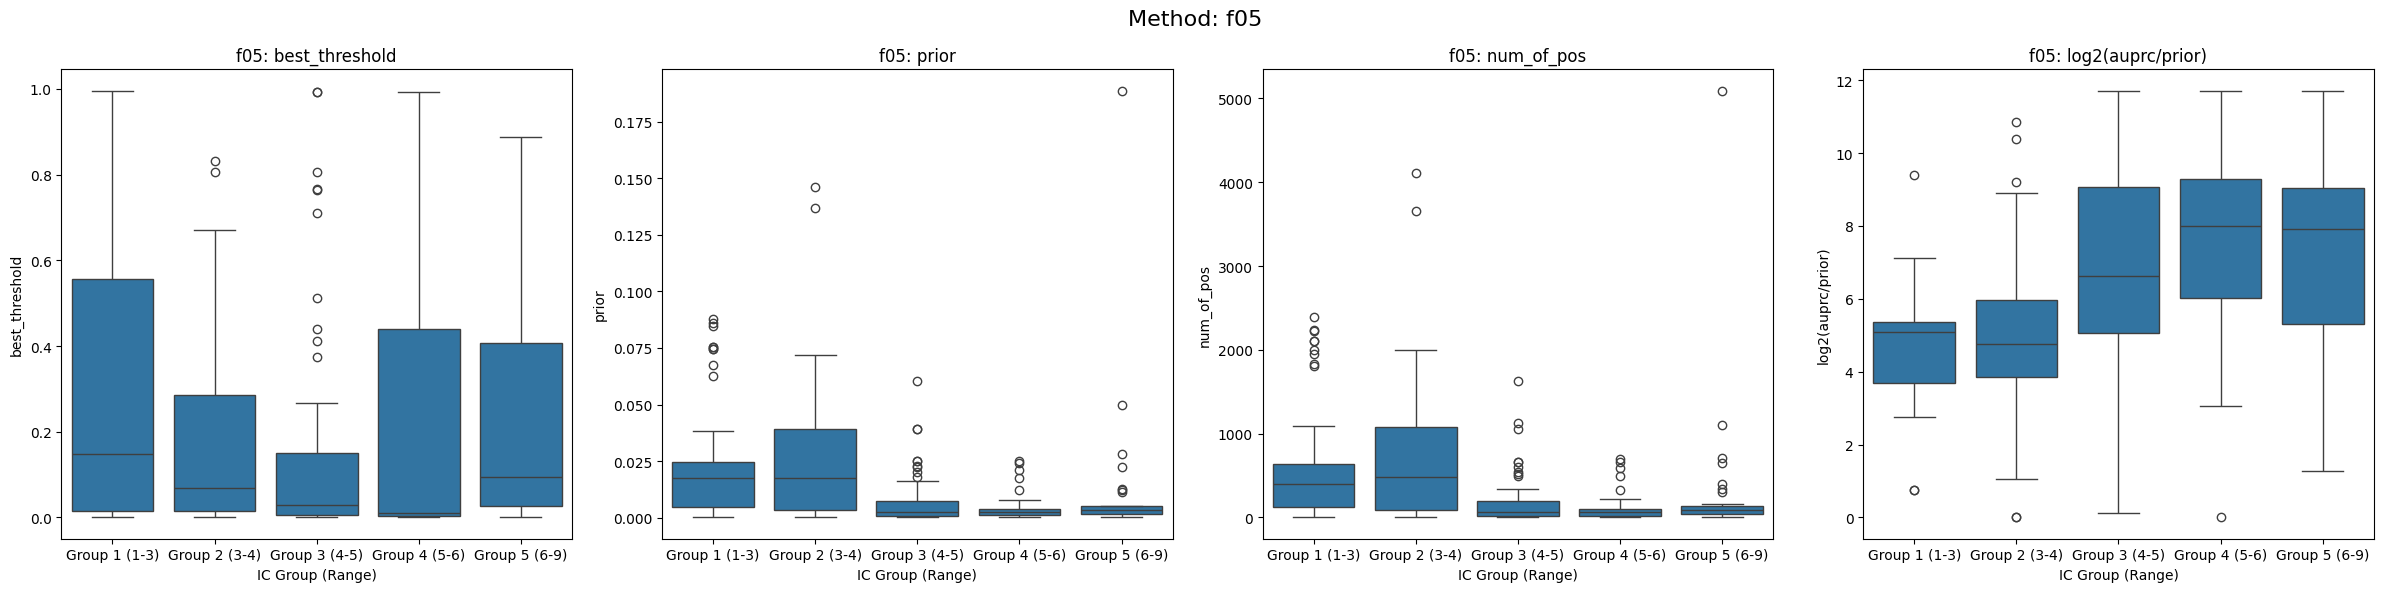

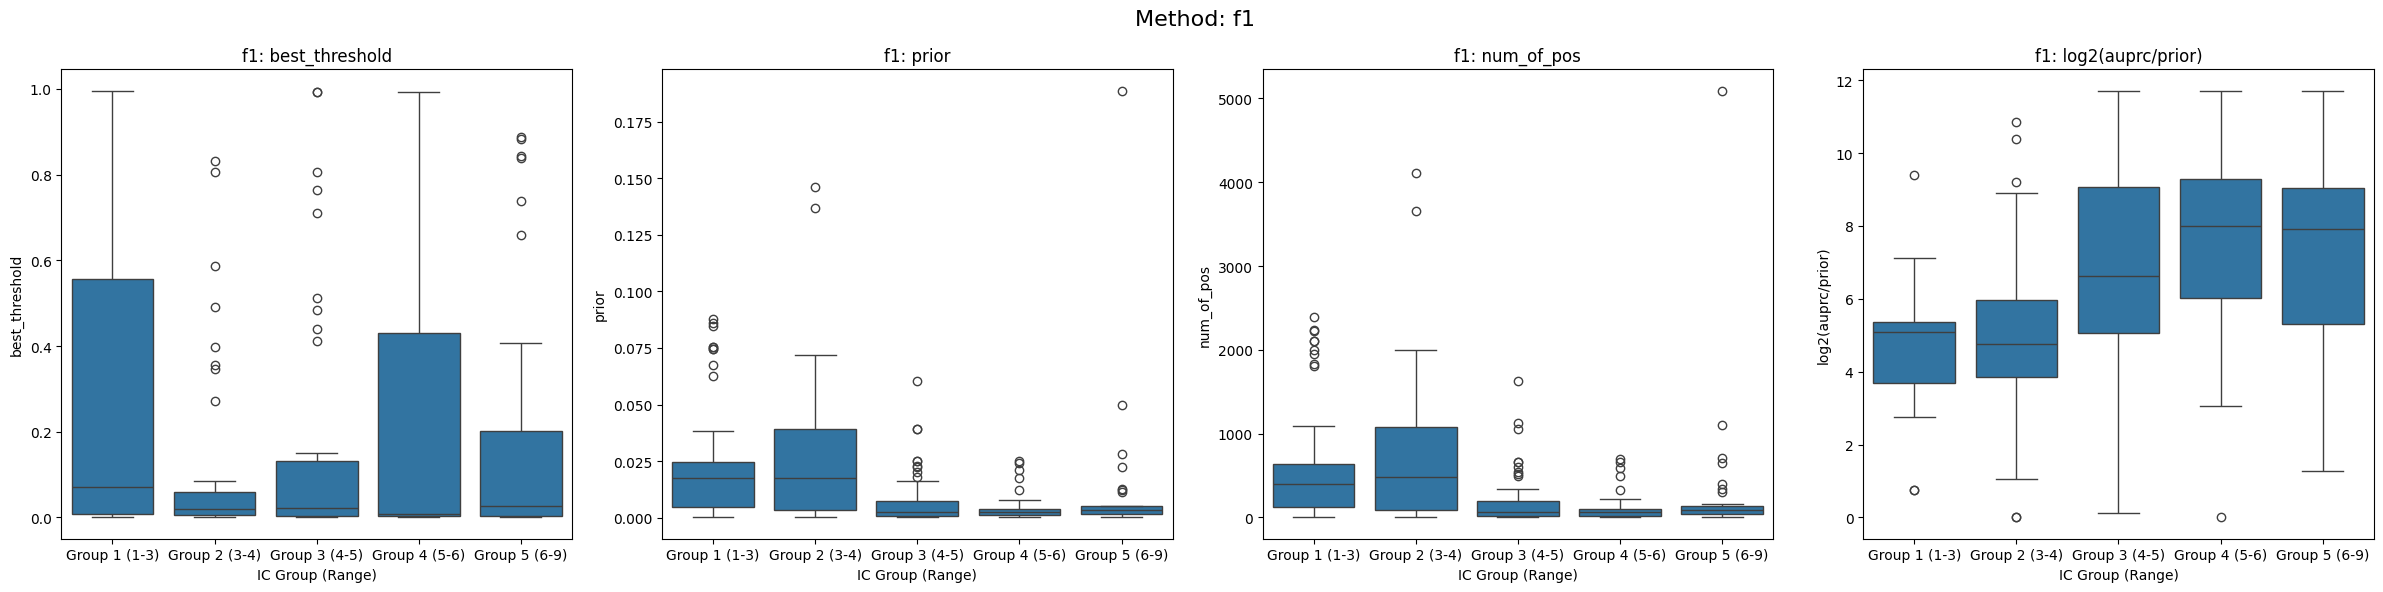

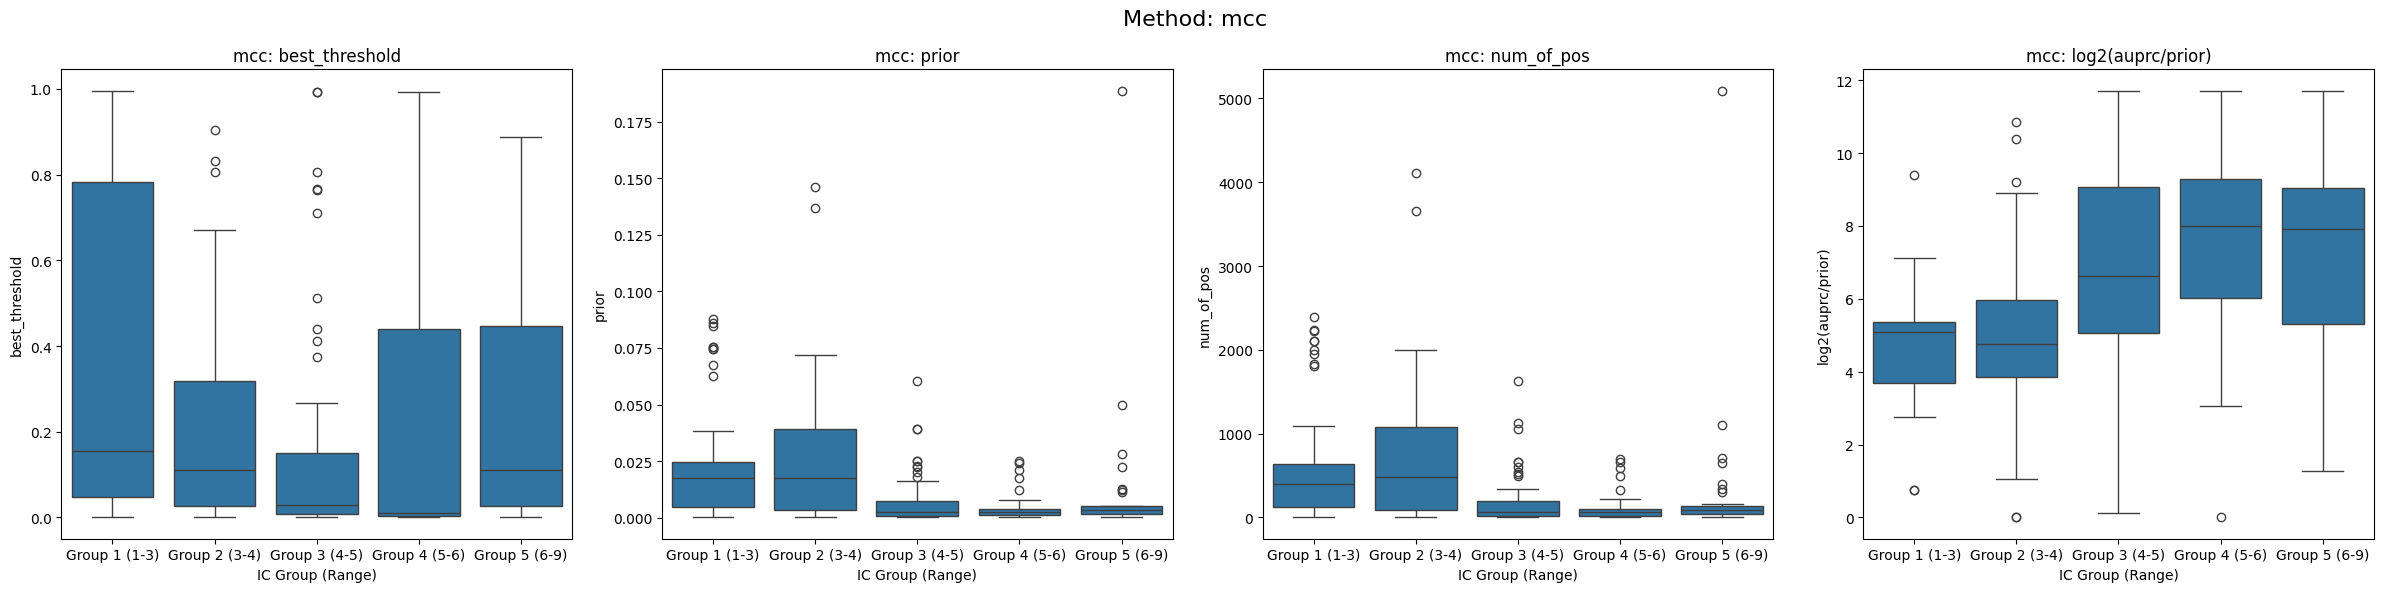

In [43]:
# Information Content vs others: boxplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by IC and create 5 groups
df = txt2onto_label_df.sort_values(by="ic")

# Create IC intervals and group labels
intervals = pd.qcut(df["ic"], 5)  # Interval objects like (0.1, 0.5]
group_labels = [f"Group {i+1}" for i in range(5)]

# Assign both
df["ic_interval"] = intervals
df["ic_group_label"] = pd.qcut(df["ic"], 5, labels=group_labels)

# Combine into one string: "Group 1 (1-4)"
df["ic_group"] = df.apply(lambda row: f"{row['ic_group_label']} ({int(row['ic_interval'].left)}-{int(row['ic_interval'].right)})", axis=1)

methods = sorted(df["method"].unique())
metrics = ["best_threshold", "prior", "num_of_pos", "log2(auprc/prior)"]

for method in methods:
    method_df = df[df["method"] == method]
    fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharex=True)
    
    for ax, metric in zip(axes, metrics):
        sns.boxplot(data=method_df, x="ic_group", y=metric, ax=ax)
        ax.set_title(f"{method}: {metric}")
        ax.set_xlabel("IC Group (Range)")
        ax.set_ylabel(metric)
    
    plt.suptitle(f"Method: {method}", fontsize=16)
    plt.tight_layout()
    plt.show()


Analysis:

1. The terms are sorted in ascending order and then split evenly into 5 groups. Each boxplot shows the distribution of the terms in a group. There is a general negative trend when the term's information content is higher for best threshold, prior, number of positives.  
2. There is a positive trend between Log2(auprc/prior) and information content.  

### GEO studies: predicted annotations

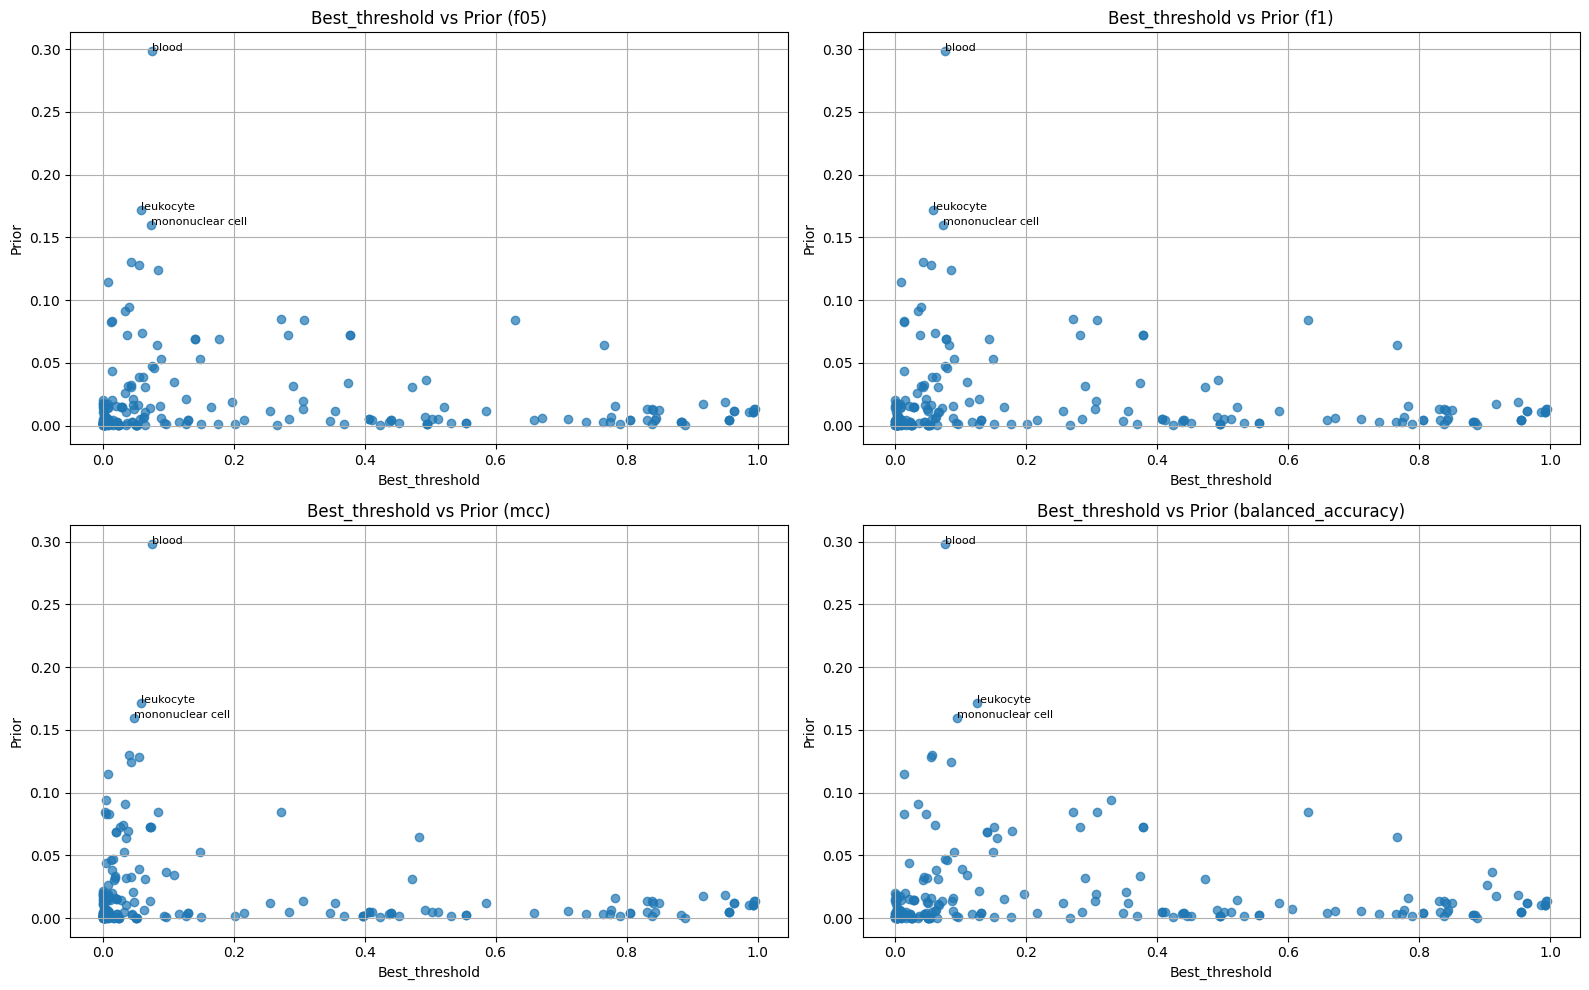

In [45]:
# best_threshold vs Prior
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "best_threshold"
y_axis = "prior"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = annotation_analysis_df[annotation_analysis_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 0.15:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()


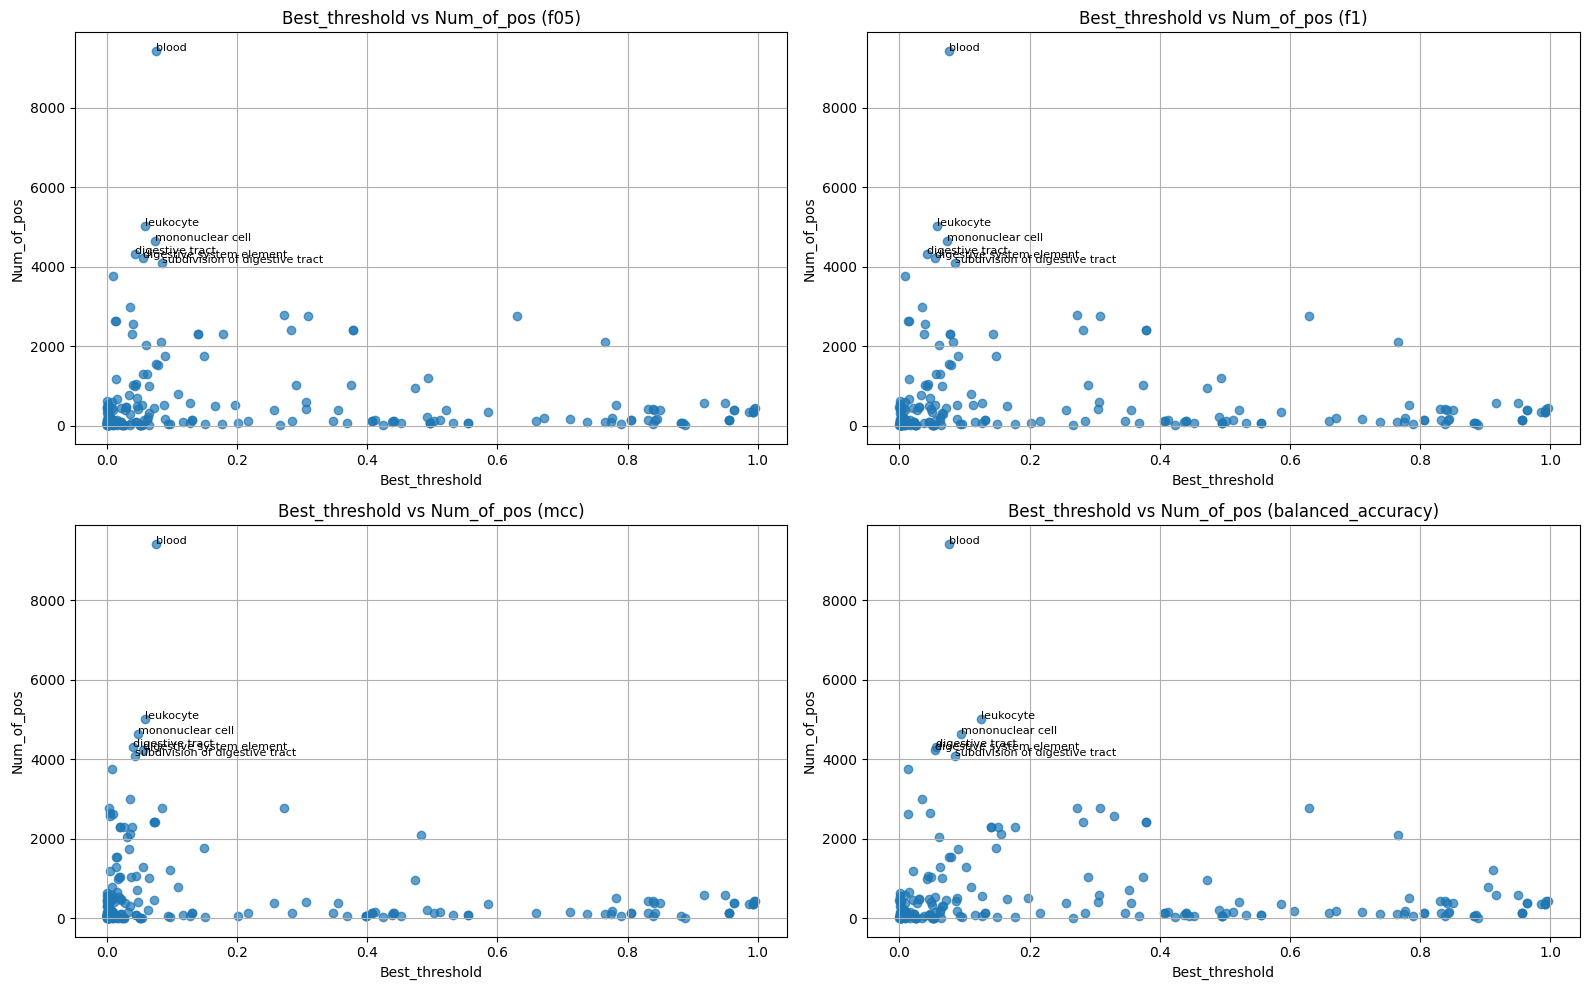

In [47]:
# best_threshold vs Number of Positives
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "best_threshold"
y_axis = "num_of_pos"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = annotation_analysis_df[annotation_analysis_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 4000:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

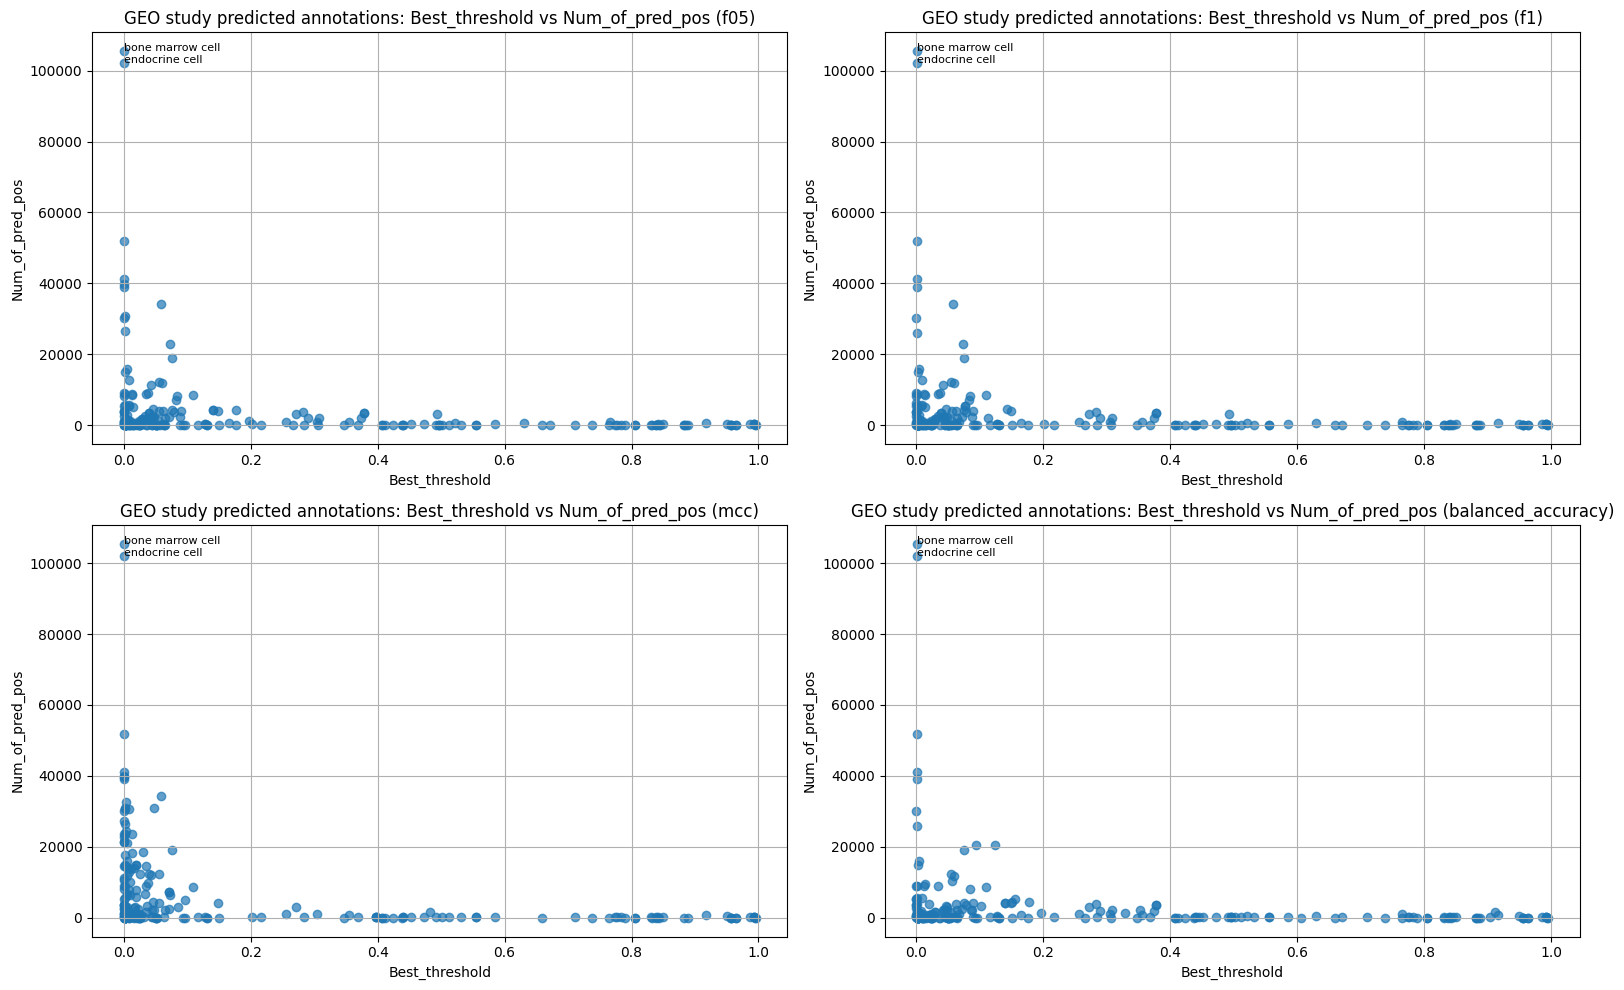

In [48]:
# best_threshold vs Number of Predicted Positives
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "best_threshold"
y_axis = "num_of_pred_pos"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = annotation_analysis_df[annotation_analysis_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 60000:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'GEO study predicted annotations: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

Analysis:

1. there is no an obvious relationship bewtween best threhold and prior, best threshold and number of positives, and best threhold and number of predicted positive. 